In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import cv2
import random
from random import randint
import numpy

from datasets.augmentations1 import train_transform
from datasets.split_data_set_combined import CustomDataset
from local_yolos.yolov5.utils.general import xywh2xyxy

from matplotlib import pyplot as plt
%matplotlib inline

torch.Size([3, 640, 640])


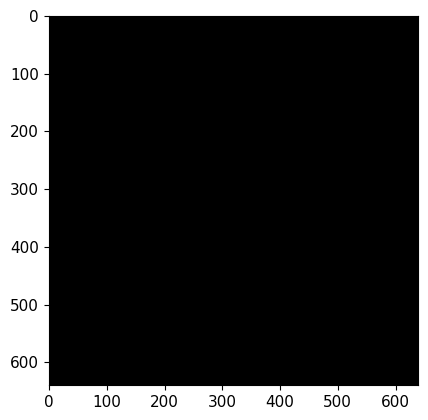

In [2]:
# reproductive
seed_value = 27
numpy.random.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 获取扰动图像
# path = 'UAP_train/yolov_5_epsilon=70_lambda1=1_lambda2=10_pre/UAP_epoch37_btach175_s_model.png'
path = 'experiments/clean/final_results/final_patch.png'

adv = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
# print(adv.shape)  # numpy数组格式为（H,W,C）
plt.imshow(adv)

adv_patch = transforms.ToTensor()(adv)  # tensor数据格式是torch(C,H,W)
adv_patch = adv_patch.to(device)
print(adv_patch.size())
# print(adv_patch)

In [4]:
# Get dataset
def collate_fn(batch):
    # print(batch)
    return tuple(zip(*batch))

image_dir = 'bdd-dataset/data/train'
idx = random.choices(range(1000), k=100)
dataset_train = CustomDataset(type_ds='train', img_dir=image_dir, transform=train_transform)
loader = DataLoader(dataset_train, batch_size=8,
                    sampler=SubsetRandomSampler(idx), collate_fn=collate_fn)

images, names = next(iter(loader))

images_clean = torch.stack(images)

images_clean = images_clean.to(device)

print(images_clean.shape)

torch.Size([8, 3, 640, 640])


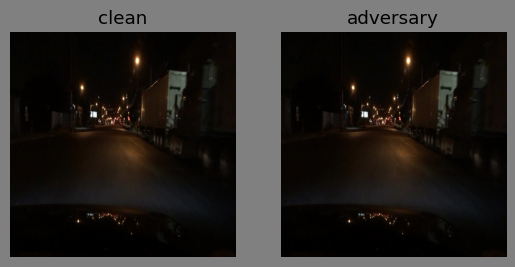

In [6]:
# add noise
images_patch = torch.clamp(images_clean[:] + adv_patch, 0, 1)
# show clean image
id = 2
image_numpy = images_clean[id].cpu().numpy().transpose(1, 2, 0)
image_numpy_p = images_patch[id].cpu().numpy().transpose(1, 2, 0)

figure, (axis1,axis2) = plt.subplots(1,2)
figure.patch.set_color('gray')  # Change background color
axis1.set_axis_off(); axis1.set_title('clean'); axis1.imshow(image_numpy)
axis2.set_axis_off(); axis2.set_title('adversary'); axis2.imshow(image_numpy_p)

In [7]:
# =========forward==========
# load model
from util.tool import get_model, forward
model_name = 'yolov8'
model = get_model(model_name)

class_name = model.module.names if hasattr(model, 'module') else model.names
colors = [(randint(0, 255), randint(0, 255), randint(0, 255)) for _ in class_name]

output_clean = forward(model, images_clean, model_name).detach()
output_patch = forward(model, images_patch, model_name).detach()
print(output_clean.shape)

YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs
torch.Size([8, 8400, 85])


In [ ]:
# =======画定位框=========
def drawImage(output, name):
    img = cv2.imread(os.path.join(image_dir, name))
    # img = cv2.resize(img, (640, 640))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    scale_w = w / 640
    scale_h = h / 640

    # draw box
    for out in output:
        x1, y1, x2, y2, conf, label = out.tolist()
        x1, y1, x2, y2, label = int(x1 * scale_w), int(y1 * scale_h), \
                                int(x2 * scale_w), int(y2 * scale_h), int(label)

        conf = f'{conf:.3}'

        color = colors[label]
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 8)
        
        string = f'{class_name[label]}'
        cv2.putText(img, string, (x1, y1 - 20), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 5)
    return img

def drawCompImage(output_c, output_p, name):
    img_clean = drawImage(output_c, name)
    img_patch = drawImage(output_p, name)

    figure, (axis1,axis2) = plt.subplots(1,2)
    figure.patch.set_color('gray')  # Change background color
    axis1.set_axis_off(); axis1.set_title(f'{name}--clean'); axis1.imshow(img_clean)
    axis2.set_axis_off(); axis2.set_title(f'adversary'); axis2.imshow(img_patch)

==============0============
==============1============
==============2============
==============3============
==============4============
==============5============
==============6============
==============7============


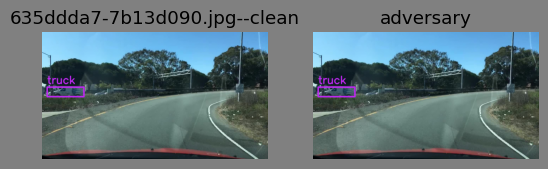

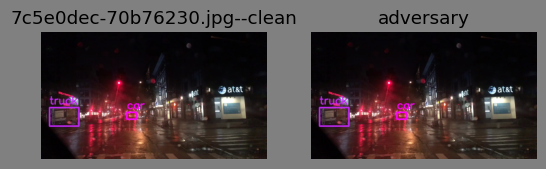

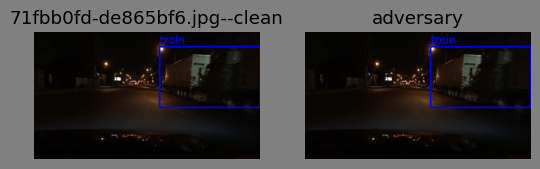

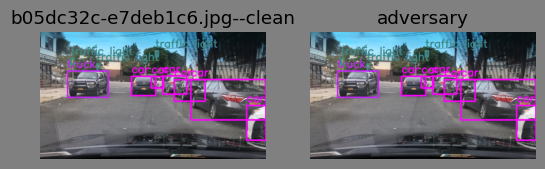

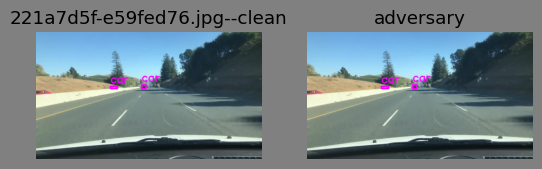

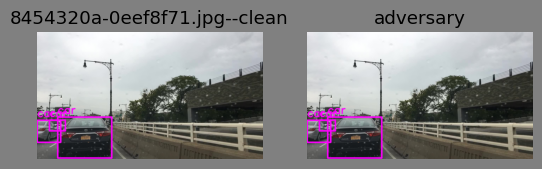

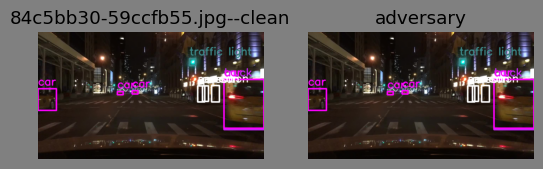

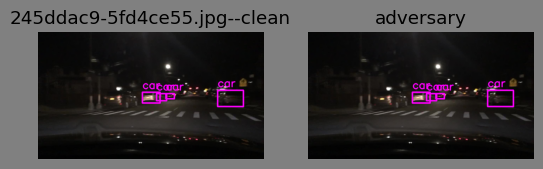

In [8]:
import time
# ========postprocessing========
conf_thres = 0.25
iou_thres = 0.45
flag = output_clean[..., 4] > conf_thres  # candidates
flag_p = output_patch[..., 4] > conf_thres  # candidates

for (i, clean), (_, patch) in zip(enumerate(output_clean), enumerate(output_patch)):
    # print(f'=============={i}============')
    x = clean[flag[i]]
    x_p = patch[flag_p[i]]

    # Compute conf
    x[:, 5:] = x[:, 5:] * x[:, 4:5]
    x_p[:, 5:] = x_p[:, 5:] * x_p[:, 4:5]

    # Box (center x, center y, width, height) to (x1, y1, x2, y2)
    box = xywh2xyxy(x[:, :4])
    box_p = xywh2xyxy(x_p[:, :4])

    # best class only
    conf, j = x[:, 5:].max(1, keepdim=True)
    x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]
    conf, j = x_p[:, 5:].max(1, keepdim=True)
    x_p = torch.cat((box_p, conf, j.float()), 1)[conf.view(-1) > conf_thres]

    # print(f'pass to NMS: clean---{len(x)}, patch---{len(x_p)}')
    # drawCompImage(x, x_p, names[i])

    # Batched NMS
    agnostic = False
    c = x[:, 5:6] * (0 if agnostic else 4096)  # classes
    boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
    nms_i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
    x_nms = x[nms_i]

    c = x_p[:, 5:6] * (0 if agnostic else 4096)  # classes
    boxes, scores = x_p[:, :4] + c, x_p[:, 4]  # boxes (offset by class), scores
    nms_i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
    x_p_nms = x_p[nms_i]

    # print(f'after NMS: clean---{len(x_nms)}, patch---{len(x_p_nms)}')
    drawCompImage(x_nms, x_p_nms, names[i])

In [ ]:
import time
# computing time
def comput_time(output):
    # ========postprocessing========
    conf_thres = 0.25
    iou_thres = 0.45
    flag = output[..., 4] > conf_thres  # candidates

    for i, x in enumerate(output):
        x = x[flag[i]]
        # Compute conf
        x[:, 5:] = x[:, 5:] * x[:, 4:5]
        # Box (center x, center y, width, height) to (x1, y1, x2, y2)
        box = xywh2xyxy(x[:, :4])
        # best class only
        conf, j = x[:, 5:].max(1, keepdim=True)
        x = torch.cat((box, conf, j.float()), 1)[conf.view(-1) > conf_thres]

        # Batched NMS
        agnostic = False
        c = x[:, 5:6] * (0 if agnostic else 4096)  # classes
        boxes, scores = x[:, :4] + c, x[:, 4]  # boxes (offset by class), scores
        nms_i = torchvision.ops.nms(boxes, scores, iou_thres)  # NMS
        x_nms = x[nms_i]

T = time.time()
comput_time(output_clean)
T1 = time.time()
comput_time(output_patch)
T2 = time.time()
print(f'NMS time: clean---{T1 - T}s, patch---{T2-T1}')

NMS time: clean---0.003702878952026367s, patch---0.43078017234802246
